In [544]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting import TimeSeriesDataSet,AutoRegressiveBaseModelWithCovariates
from pytorch_forecasting.metrics import MAE,RMSE,SMAPE
from pytorch_forecasting.metrics import MultiHorizonMetric
import os
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from pytorch_forecasting.models.nn import LSTM
from typing import Dict,Tuple,List
from sklearn.preprocessing import StandardScaler
import random

In [545]:
stream = pd.read_pickle(os.path.join('..','data','processed','stream_processed.pkl'),compression= 'zip')
meteo = pd.read_pickle(os.path.join('..','data','processed','meteo_processed.pkl'),compression = 'zip')
stream

measurement_location,Datum,15202300,15205501,15207507,15210206,15212008,15212700,15213500,15214003,15214604,15216009,15217908,15221009,15228008,15241006,15242304,15243001,15246000,15247002,15247501
0,2014-01-01,14.4,17.2,19.8,3.87,8.66,9.66,0.433,2.35,0.207,1.66,0.921,0.671,2.59,0.253,0.870,1.26,2.35,0.355,0.120
1,2014-01-02,14.4,17.0,19.3,3.78,8.52,9.46,0.435,2.51,0.204,1.62,0.909,0.664,2.57,0.253,0.870,1.23,2.32,0.361,0.131
2,2014-01-03,14.1,16.6,19.3,3.78,8.40,9.42,0.429,2.61,0.201,1.60,0.907,0.641,2.58,0.253,0.871,1.23,2.30,0.362,0.130
3,2014-01-04,14.2,16.6,19.3,3.84,8.57,9.50,0.445,2.49,0.214,1.64,0.935,0.642,2.60,0.256,0.929,1.26,2.44,0.382,0.127
4,2014-01-05,16.4,18.4,20.6,4.36,9.94,10.80,0.545,2.86,0.267,1.80,1.130,0.690,3.10,0.300,1.150,1.61,3.14,0.561,0.175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,2023-12-28,79.7,102.0,120.0,28.50,46.20,57.10,1.900,17.30,0.721,10.30,6.070,3.920,12.20,0.786,3.270,9.05,12.50,2.020,0.741
3649,2023-12-29,71.4,82.5,97.7,26.00,41.90,51.30,1.710,15.60,0.801,9.85,5.480,3.470,10.90,0.653,2.890,7.23,9.97,1.750,0.619
3650,2023-12-30,64.0,71.4,86.3,24.40,38.60,46.90,1.530,14.70,0.835,9.40,4.900,3.100,9.77,0.557,2.550,5.92,8.54,1.470,0.514
3651,2023-12-31,59.1,63.0,77.3,22.20,35.30,42.50,1.410,13.10,0.669,8.83,4.480,2.670,8.92,0.492,2.330,5.40,7.66,1.290,0.458


In [546]:
def mean_meteo(df : pd.DataFrame,meteo : str):
    in_df = df.copy()[[col for col in df.columns if meteo in col]]
    return in_df.mean(axis = 1)
    
    

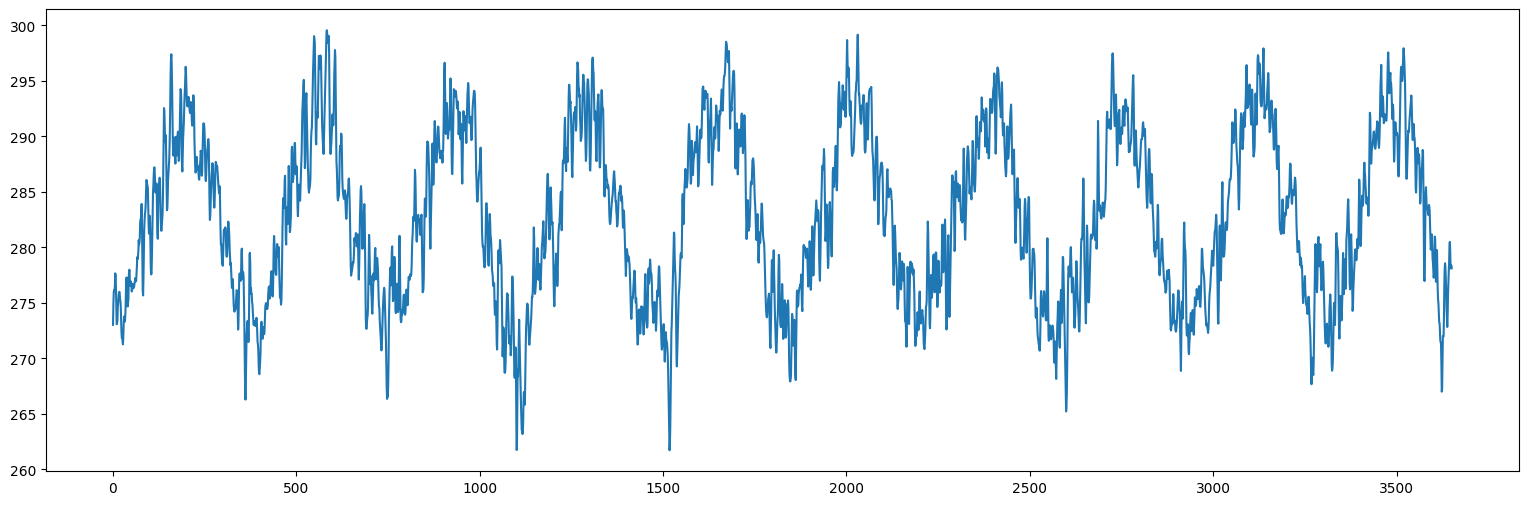

In [547]:
plt.figure(figsize=(19,6))
plt.plot(mean_meteo(meteo,'t2m').rolling(3,center = True).mean())

In [548]:
stream[list(stream.columns[1:])] = stream[list(stream.columns[1:])].rolling(window=3).mean()

In [549]:

meteo_vars = ['t2m','tp','ssr','d2m','sp']

for var in meteo_vars:
    meteo[f"mean_{var}"] = mean_meteo(meteo,var)

tp_to_drop = [col for col in meteo.columns if 'tp_' in col]
d2m_to_drop = [col for col in meteo.columns if 'd2m_' in col]
ssr_to_drop = [col for col in meteo.columns if 'ssr_' in col]
t2m_to_drop = [col for col in meteo.columns if 't2m_' in col]
sp_tp_drop = [col for col in meteo.columns if 'sp_' in col]
cols_to_drop = tp_to_drop + d2m_to_drop + ssr_to_drop + t2m_to_drop + sp_tp_drop
meteo = meteo.drop(columns = cols_to_drop)
meteo[['mean_t2m','mean_tp','mean_ssr','mean_d2m','mean_sp']] = meteo[['mean_t2m','mean_tp','mean_ssr','mean_d2m','mean_sp']].rolling(3).mean()
meteo = meteo.dropna()
meteo.head()

,date,mean_t2m,mean_tp,mean_ssr,mean_d2m,mean_sp
2,2014-01-03,273.021965,0.000003,119146.173438,271.883361,95313.604938
3,2014-01-04,274.925370,0.000063,126557.485226,273.071493,95113.810892
4,2014-01-05,275.965074,0.000089,101905.371445,274.455001,95083.448483
5,2014-01-06,276.129214,0.000097,99399.849663,274.637074,95148.867959
6,2014-01-07,276.075047,0.000038,114978.027700,274.781352,95473.672910


In [550]:
stream = stream.iloc[:3652]
meteo = meteo.drop(columns = 'date')
data = stream.join(meteo).drop(columns = 'Datum').dropna()
data['groups'] = 0
data['date'] = data.index
data

,15202300,15205501,15207507,15210206,15212008,15212700,15213500,15214003,15214604,15216009,...,15246000,15247002,15247501,mean_t2m,mean_tp,mean_ssr,mean_d2m,mean_sp,groups,date
2,14.300000,16.933333,19.466667,3.810000,8.526667,9.513333,0.432333,2.490000,0.204000,1.626667,...,2.323333,0.359333,0.127000,273.021965,0.000003,119146.173438,271.883361,95313.604938,0,2
3,14.233333,16.733333,19.300000,3.800000,8.496667,9.460000,0.436333,2.536667,0.206333,1.620000,...,2.353333,0.368333,0.129333,274.925370,0.000063,126557.485226,273.071493,95113.810892,0,3
4,14.900000,17.200000,19.733333,3.993333,8.970000,9.906667,0.473000,2.653333,0.227333,1.680000,...,2.626667,0.435000,0.144000,275.965074,0.000089,101905.371445,274.455001,95083.448483,0,4
5,16.300000,18.800000,21.433333,4.193333,9.736667,10.600000,0.504667,2.740000,0.239333,1.740000,...,2.866667,0.477000,0.152667,276.129214,0.000097,99399.849663,274.637074,95148.867959,0,5
6,16.733333,19.800000,22.966667,4.260000,10.083333,10.900000,0.515333,2.776667,0.241000,1.750000,...,2.963333,0.493333,0.156000,276.075047,0.000038,114978.027700,274.781352,95473.672910,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,139.733333,211.000000,240.000000,45.500000,79.500000,100.166667,3.023333,32.000000,2.451000,12.270000,...,23.933333,3.910000,1.762000,279.720414,0.000105,43848.074041,276.986864,95735.617496,0,3647
3648,100.966667,150.000000,172.666667,33.833333,56.900000,71.533333,2.296667,22.633333,1.164667,10.370000,...,17.433333,2.633333,1.035667,278.115081,0.000021,75076.971920,275.530633,95956.563242,0,3648
3649,82.100000,107.500000,126.233333,29.033333,47.366667,58.733333,1.940000,18.133333,0.838333,10.020000,...,13.023333,2.100000,0.772000,278.131672,0.000016,113272.033552,275.687857,95952.454680,0,3649
3650,71.700000,85.300000,101.333333,26.300000,42.233333,51.766667,1.713333,15.866667,0.785667,9.850000,...,10.336667,1.746667,0.624667,278.368488,0.000021,120318.203430,275.602084,95795.413570,0,3650


In [551]:
list(data.columns[19:24])

['mean_t2m', 'mean_tp', 'mean_ssr', 'mean_d2m', 'mean_sp']

In [552]:
max_pred_len = 7
enc_len = 364
# training_cutoff = int(data["date"].max()*0.7) - max_pred_len
val_cutoff = int(data["date"].max()*0.15) - max_pred_len
test_cutoff = int(data["date"].max()*0.3)- max_pred_len

training = TimeSeriesDataSet(
    data= data.iloc[test_cutoff:],
    target='15207507',#'15207507'
    group_ids=['groups'],#groups
    time_idx='date',#date
    min_prediction_idx=test_cutoff,
    max_encoder_length=enc_len,
    min_encoder_length=enc_len,
    min_prediction_length=max_pred_len,
    max_prediction_length=max_pred_len,
    time_varying_unknown_reals=['15207507'],
    time_varying_known_reals=['mean_t2m','mean_tp']#data.columns[20:-1].values.tolist(),
)

validation = TimeSeriesDataSet.from_dataset(training,data.iloc[: val_cutoff],min_prediction_idx=0,stop_randomization=True)

train_dataloader = training.to_dataloader(train=True, batch_size=128, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=32, num_workers=2)


In [553]:
next(iter(training))[0]['x_cont'].shape

torch.Size([371, 3])

/var/folders/4t/_4f_khl520s03z4ltmxqlnsh0000gn/T/ipykernel_78545/3937294667.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stream['Datum'] = pd.to_datetime(stream['Datum'])


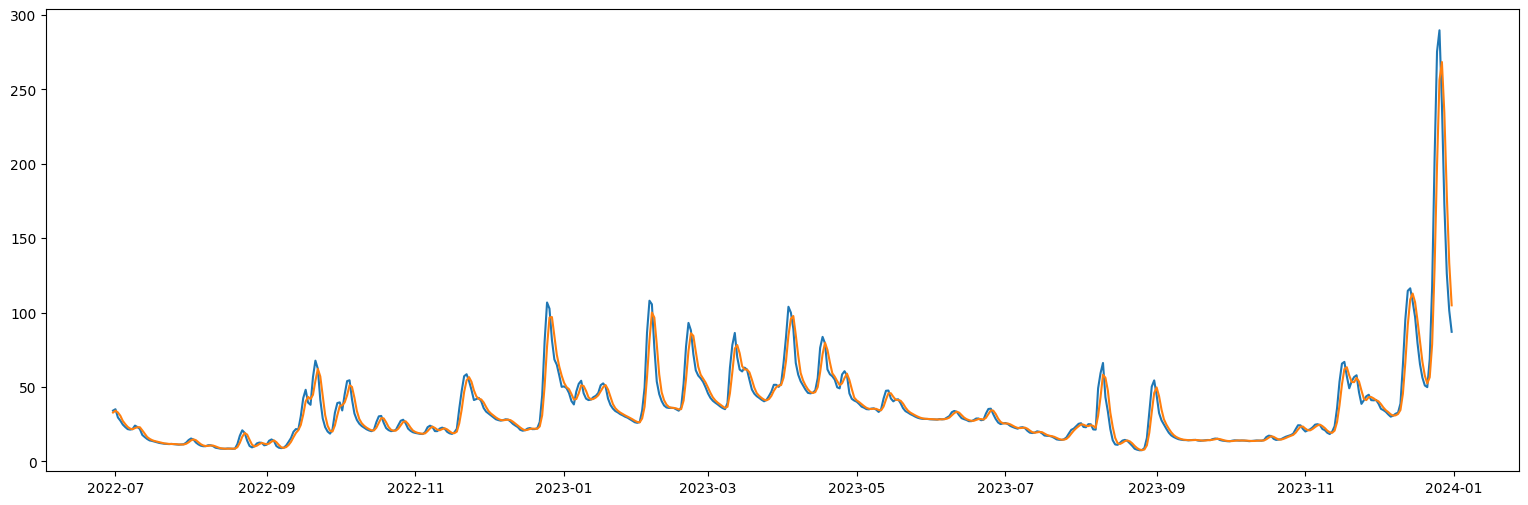

In [554]:
plt.figure(figsize=(19, 6))
stream['Datum'] = pd.to_datetime(stream['Datum'])
stream = stream.set_index('Datum')
plt.plot(stream['15207507'].iloc[-550:])
plt.plot(stream['15207507'].rolling(window=3).mean().iloc[-550:])

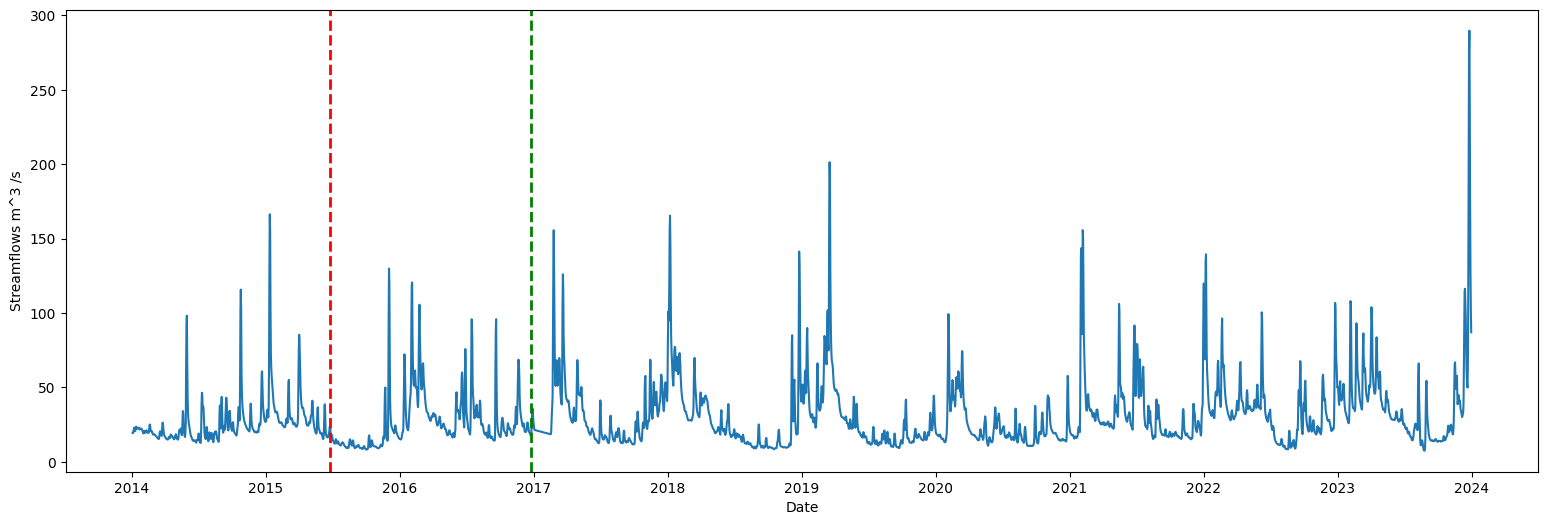

In [555]:
plt.figure(figsize=(19, 6))
plt.plot(stream.index,stream['15207507'])
plt.xlabel('Date')
plt.ylabel('Streamflows m^3 /s')
plt.axvline(x=stream.index[val_cutoff], color='r', linestyle='--', linewidth=2)
plt.axvline(x=stream.index[test_cutoff], color='g', linestyle='--', linewidth=2)

In [556]:
# class KGE(MultiHorizonMetric):
#     def loss(self, y_pred, target):
#         y_pred = self.to_prediction(y_pred)

#         kge_list = []
#         for i in range(y_pred.size(0)):
#             pred = y_pred[i,:]
#             true = target[i,:]

#             # Compute correlation coefficient
#             r = torch.corrcoef(torch.stack((pred, true)))[0, 1]
            
#             # Compute alpha and beta
#             alpha = pred.std() / true.std()
#             beta = pred.mean() / true.mean()
            
#             # Calculate KGE
#             kge = 1 - torch.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
            
#             kge_list.append(kge)

#         kge_tensor = torch.stack(kge_list)
#         mean_kge = kge_tensor.mean()
            
#         return -1 * mean_kge

In [557]:
class LSTMModel(AutoRegressiveBaseModelWithCovariates):
    def __init__(
        self,
        input_size:int,
        target: str,
        target_lags: Dict[str, Dict[str, int]],
        n_layers: int,
        hidden_size: int,
        x_reals: List[str],
        x_categoricals: List[str],
        embedding_sizes: Dict[str, Tuple[int, int]],
        embedding_labels: Dict[str, List[str]],
        static_categoricals: List[str],
        static_reals: List[str],
        time_varying_categoricals_encoder: List[str],
        time_varying_categoricals_decoder: List[str],
        time_varying_reals_encoder: List[str],
        time_varying_reals_decoder: List[str],
        embedding_paddings: List[str],
        categorical_groups: Dict[str, List[str]],
        dropout: float = 0.2,
        **kwargs,

    ):
        # arguments target and target_lags are required for autoregressive models
        # even though target_lags cannot be used without covariates
        # saves arguments in signature to `.hparams` attribute, mandatory call - do not skip this
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call - do not skip this
        super().__init__(**kwargs)

        # use version of LSTM that can handle zero-length sequences
        self.lstm = LSTM(
            hidden_size=self.hparams.hidden_size,
            input_size=self.hparams.input_size,
            num_layers=self.hparams.n_layers,
            dropout=self.hparams.dropout,
            batch_first=True,
        )
        self.dropout_layer = nn.Dropout(p = 0.2)
        self.output_layer = nn.Linear(self.hparams.hidden_size, 1)

    def encode(self, x: Dict[str, torch.Tensor]):
        # we need at least one encoding step as because the target needs to be lagged by one time step
        # because we use the custom LSTM, we do not have to require encoder lengths of > 1
        # but can handle lengths of >= 1
        assert x["encoder_lengths"].min() >= 1
        input_vector = x["encoder_cont"].clone()

        # run through LSTM network
        _, hidden_state = self.lstm(
            input_vector, enforce_sorted=False  # passing the lengths directly
        )  # second ouput is not needed (hidden state)
        return hidden_state

    def decode(self, x: Dict[str, torch.Tensor], hidden_state):
        # again lag target by one
        input_vector = x["decoder_cont"].clone()
        input_vector[..., self.target_positions] = torch.roll(
            input_vector[..., self.target_positions], shifts=1, dims=1
        )
        # but this time fill in missing target from encoder_cont at the first time step instead of throwing it away
        last_encoder_target = x["encoder_cont"][
            torch.arange(x["encoder_cont"].size(0), device=x["encoder_cont"].device),
            x["encoder_lengths"] - 1,
            self.target_positions.unsqueeze(-1),
        ].T
        input_vector[:, 0, self.target_positions] = last_encoder_target

        if self.training:  # training mode
            lstm_output, _ = self.lstm(input_vector, hidden_state, lengths=x["decoder_lengths"], enforce_sorted=False)

            # transform into right shape
            prediction = self.output_layer(lstm_output)
            prediction = self.transform_output(prediction, target_scale=x["target_scale"])

            # predictions are not yet rescaled
            return prediction

        else:  # prediction mode
            target_pos = self.target_positions

            def decode_one(idx, lagged_targets, hidden_state):
                x = input_vector[:, [idx]]
                # overwrite at target positions
                x[:, 0, target_pos] = lagged_targets[-1]  # take most recent target (i.e. lag=1)
                lstm_output, hidden_state = self.lstm(x, hidden_state)
                # transform into right shape
                prediction = self.output_layer(lstm_output)[:, 0]  # take first timestepself.dropout_layer(
                return prediction, hidden_state

            # make predictions which are fed into next step
            output = self.decode_autoregressive(
                decode_one,
                first_target=input_vector[:, 0, target_pos],
                first_hidden_state=hidden_state,
                target_scale=x["target_scale"],
                n_decoder_steps=input_vector.size(1),
            )

            # predictions are already rescaled
            return output

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        hidden_state = self.encode(x)  # encode to hidden state
        output = self.decode(x, hidden_state)  # decode leveraging hidden state

        return self.to_network_output(prediction=output)



model = LSTMModel.from_dataset(training,
                               input_size = 3,
                               learning_rate = 0.001,
                               n_layers=1,
                               hidden_size = 128,
                               loss = MAE(),
                               dropout = 0.2,
                               optimizer = 'adam',
                               reduce_on_plateau_patience = 7,
                               reduce_on_plateau_min_lr = 0.00005,
                               weight_decay = 0.001
                               )

/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [558]:
# early_stopping_callback = EarlyStopping(
#     monitor='val_loss',  # metric to monitor
#     patience=5,          # number of epochs with no improvement after which training will be stopped
#     mode='min',          # 'min' if the monitored metric should be minimized
#     verbose=True         # print messages when early stopping
# )

In [559]:
trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=100,
    log_every_n_steps=17,
    # callbacks=[early_stopping_callback],
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [560]:
# fit network
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MAE        | 0     
1 | logging_metrics | ModuleList | 0     
2 | lstm            | LSTM       | 68.1 K
3 | dropout_layer   | Dropout    | 0     
4 | output_layer    | Linear     | 129   
-----------------------------------------------
68.2 K    Trainable params
0         Non-trainable params
68.2 K    Total params
0.273     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [561]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_lstm = LSTMModel.load_from_checkpoint(best_model_path)#os.path.join(best_model_path,'lightning_logs','version_24','checkpoints','epoch=19-step=680.ckpt'))


In [562]:
test = TimeSeriesDataSet.from_dataset(training,data[:test_cutoff-2],min_prediction_idx= val_cutoff,stop_randomization=True)
test_dataloader = test.to_dataloader(train=False, batch_size=1, num_workers=2)
len(test)

542

In [563]:
predictions = best_lstm.predict(test_dataloader,return_y=True,trainer_kwargs=dict(accelerator="cpu"))


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


In [564]:
def kge(inputs,targets):
    r = torch.corrcoef(torch.stack((inputs.squeeze(),targets)))[0][1]
    alpha = inputs.std()/targets.std()
    beta = inputs.mean()/targets.mean()
    kge = torch.sqrt(torch.square(r-1) + torch.square(alpha-1) + torch.square(beta-1))
    return 1 - kge

In [565]:
results = {}
for i in range(predictions.output.size(1)):
    if i == 0:
        results[f"lag: {max_pred_len - i }"] = kge(torch.tensor(stream['15207507'].iloc[val_cutoff :test_cutoff- max_pred_len+1].values),predictions.output[:,max_pred_len-i-1])
        continue
    results[f"lag: {max_pred_len - i}"] = kge(torch.tensor(stream['15207507'].iloc[val_cutoff :test_cutoff-max_pred_len+1].values),predictions.output[:,max_pred_len-i-1])

results 

{'lag: 7': tensor(0.1830, dtype=torch.float64),
 'lag: 6': tensor(0.2495, dtype=torch.float64),
 'lag: 5': tensor(0.3304, dtype=torch.float64),
 'lag: 4': tensor(0.4362, dtype=torch.float64),
 'lag: 3': tensor(0.5702, dtype=torch.float64),
 'lag: 2': tensor(0.7275, dtype=torch.float64),
 'lag: 1': tensor(0.8851, dtype=torch.float64)}

In [566]:
#save results
pd.DataFrame(results,index=[0]).to_csv(os.path.join('..','results','LSTM_res',f"lead_time_{max_pred_len}_results.csv"))


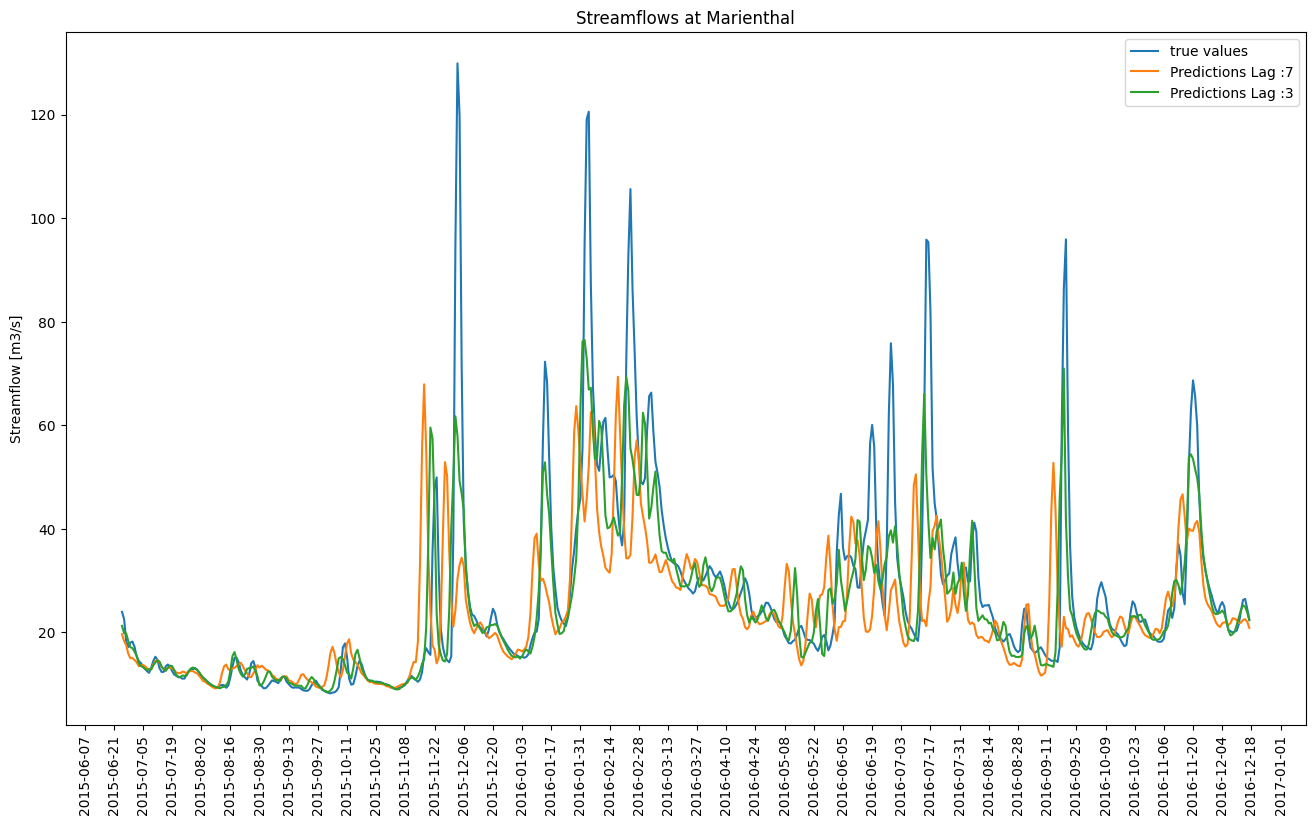

In [567]:
import matplotlib.dates as mdates


# stream_plot = stream.set_index('Datum')
stream_plot = stream.copy()
predictions_np = predictions.output[:,max_pred_len-1].numpy()#[:,max_pred_len-1]
# true_values_np = predictions.y[0].view(-1, 1).squeeze().numpy()

# Plotting

plt.figure(figsize=(16, 9))


plt.plot(stream_plot.index[val_cutoff:test_cutoff- max_pred_len+1],stream_plot['15207507'].iloc[val_cutoff :test_cutoff - max_pred_len + 1].values,  label = 'true values')

for i in range(0,predictions.output.size(1),4):
    predictions_np = predictions.output[:,max_pred_len-i-1].numpy()
    if i == 0:
        plt.plot(stream_plot.index[val_cutoff:test_cutoff- max_pred_len+1],predictions_np, label=f"Predictions Lag :{max_pred_len}")
        continue
    plt.plot(stream_plot.index[val_cutoff:test_cutoff- max_pred_len+1],predictions_np, label=f"Predictions Lag :{max_pred_len-i}")


plt.ylabel('Streamflow [m3/s]')
plt.title('Streamflows at Marienthal')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.legend()
plt.xticks(rotation=90)
plt.show()